In [1]:
from IPython.display import display

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Customer-Churn.csv')
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Data Normalization

As TotalCharges must be a number, let's converting it to numbers  
_coerce_ option will replace all nonnumeric values with a NaN

In [4]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


We see that indeed there are spaces in the TotalCharges column, let's set the missing values to zero

In [5]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

Column names naming convention

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

Churn... it's categorical, with two values, yes and no. For binary classification, all models typically expect a number: 0 for no and 1 for yes. So let's convert it to numbers

In [7]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

## Data split

In [8]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state= 1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

## Exploratory Data Analysis

In [9]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Let's get the churn rate

In [10]:
global_mean = df_train_full.churn.mean()
round(global_mean,3)

0.27

In [11]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents','phoneservice', 'multiplelines', 'internetservice','onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies','contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [12]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature Importance

In [13]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()

print('Female churn mean: ',female_mean)
print('Male churn mean: ',male_mean)

Female churn mean:  0.27682403433476394
Male churn mean:  0.2632135306553911


That indicates that knowing the gender of the customer doesn't help us identify wheter they will churn, let's check _partner_

In [14]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()

print('Partner_yes churn mean:', partner_yes)
print('Partner_no churn mean:', partner_no)

Partner_yes churn mean: 0.20503330866025166
Partner_no churn mean: 0.3298090040927694


It means that clients with no partner are more likely to churn than the ones with a partner

### Risk Ratio

In [15]:
global_mean = df_train_full.churn.mean()

df_group = df_train_full.groupby(by='gender').churn.agg(['mean']) # computes the average churn
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean

df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


Let's now do that for all categorical variables

In [16]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['rate'] = df_group['mean'] / global_mean
    display(df_group) # to render a dataframe inside the loop

,mean,diff,rate
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,rate
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,rate
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,rate
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,rate
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,rate
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,rate
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,rate
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,rate
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,rate
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,rate
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,rate
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,rate
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,rate
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,rate
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,rate
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


## Mutual Information

In [17]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


## Correlation Coefficient

In [18]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

## Feature engineering

### One-hot encoding for categorical variables

In [19]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [20]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [21]:
X_train = dv.transform(train_dict)

X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

In [22]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

## ML for classification

### Logistic Regression

In [23]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [24]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [25]:
y_pred = model.predict_proba(X_val)

model.predict_proba(X_val)

array([[0.76509544, 0.23490456],
       [0.73115212, 0.26884788],
       [0.680551  , 0.319449  ],
       ...,
       [0.94275194, 0.05724806],
       [0.38477284, 0.61522716],
       [0.93872722, 0.06127278]])

In [26]:
y_pred = model.predict_proba(X_val)[:,1]

y_pred

array([0.23490456, 0.26884788, 0.319449  , ..., 0.05724806, 0.61522716,
       0.06127278])

In [27]:
churn = y_pred >= 0.5

In [28]:
(y_val == churn).mean() # calculate accuracy

0.8016129032258065

## Model Interpretation

GEt the bias

In [29]:
model.intercept_[0]

-0.12198806745062483

which feature is associated with each weight

In [30]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


Let's train a simpler and smaller model that uses only three variables _contract, tenure and total charges_  
To use contract, we need to apply one-hot encoding 

In [31]:
small_subset = ['contract', 'tenure', 'totalcharges']

train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

In [32]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

Let's train the small model on this set of features:

In [33]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

Let's first check the bias term

In [34]:
model_small.intercept_[0]

-0.5772299128645278

In [35]:
dict(zip(dv_small.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'tenure': -0.03,
 'totalcharges': -0.092}

## Using the model

In [36]:
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75,
}

In [37]:
X_test = dv.transform([customer])

X_test

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 7.98500e+01, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 4.10000e+01, 3.32075e+03]])

In [38]:
model.predict_proba(X_test)

array([[0.92667376, 0.07332624]])

Let's try another client

In [39]:
customer = {
    'gender': 'female',
    'seniorcitizen': 1,
    'partner': 'no',
    'dependents': 'no',
    'phoneservice': 'yes',
    'multiplelines': 'yes',
    'internetservice': 'fiber_optic',
    'onlinesecurity': 'no',
    'onlinebackup': 'no',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'yes',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 85.7,
    'totalcharges': 85.7
}

In [40]:
X_test = dv.transform([customer])

model.predict_proba(X_test)[0,1]

0.832163753426764

# Evaluating Metrics

## Accuracy

In [41]:
y_pred = model.predict_proba(X_val)[:,1]  # GEts the predictions form the model
churn = y_pred >= 0.5 # Makes "Hard" predictions, using 0.5 as the threshold
(churn == y_val).mean() # Computes the accuracy

0.8016129032258065

In [42]:
from sklearn.metrics import accuracy_score

Now we can loop over different thresholds and check which one gives the best accuracy

In [43]:
thresholds = np.linspace(0, 1, 11) # Creates an array with different thresholds: 0.0, 0.1, 0.2, ... 1

for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn) # Uses the accuracy_score function from scikit for computing accuracy
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


the same but more visual

In [44]:
thresholds = np.linspace(0,1,21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)

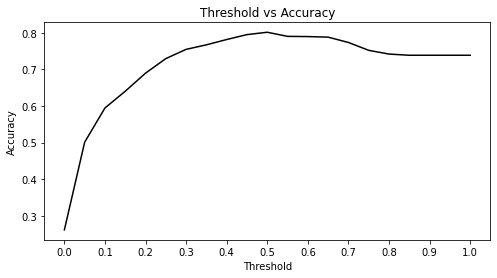

In [45]:
plt.figure(figsize=(8, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

plt.show()

In [46]:
val_dict_small = df_val[small_subset].to_dict(orient='records') # applies one hot encoding to the validation data
X_small_val = dv_small.transform(val_dict_small) 
y_pred_small = model_small.predict_proba(X_small_val)[:,1] # predicts churn using the small model

churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)  #calculates the accuracy of the predictions

0.7672043010752688

## Dummy Baseline

In [47]:
size_val = len(y_val) # gets the number of customers in the validation set
baseline = np.repeat(False, size_val) # creates an array with obly false elements

In [48]:
accuracy_score(baseline, y_val)

0.7387096774193549

## Confusion table

In [49]:
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()

In [50]:
confusion_table = np.array(
    [[true_negative, false_positive],
    [false_negative, true_positive]]
)

confusion_table

array([[1202,  172],
       [ 197,  289]])

We can turn them into fractions to understand better

In [51]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

In [52]:
 precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

precision, recall

(0.6268980477223427, 0.5946502057613169)

## ROC and AUC

Instead of evaluating the model at one particular threshold, we can do it for a range of them

In [53]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t,tp,fp,fn,tn))
    
df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


Now we can compute the TPR and FPR scores. Because the data is now in a dataframe, we can do it for all the values at once

In [54]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


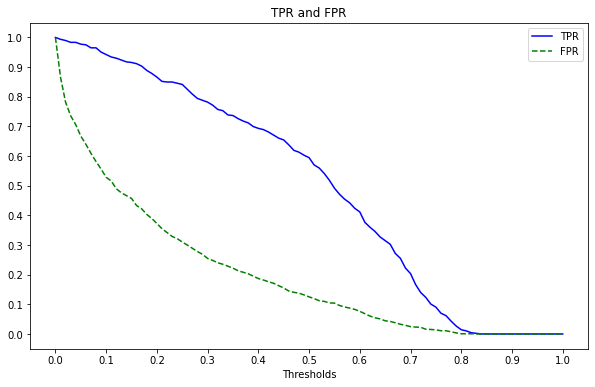

In [55]:
plt.figure(figsize=(10, 6))

plt.plot(df_scores.threshold, df_scores.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='green', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')


plt.show()

## Random Baseline Model

### A Dummy Model

A random model outputs a random score between 0 and 1, regardless of the input.

In [56]:
np.random.seed(1)

y_rand = np.random.uniform(0,1, size=len(y_val))

Now we can simply pretend that y_rand contains the predictions of our model

In [57]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)
    
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t,tp,fp,fn,tn))
        
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [58]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


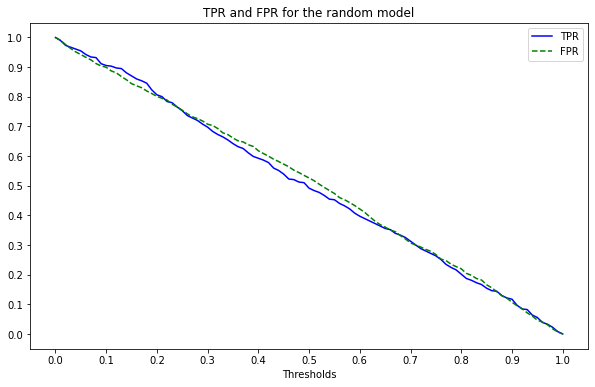

In [59]:
plt.figure(figsize=(10, 6))

plt.plot(df_rand.threshold, df_rand.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='green', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')


plt.show()

### The ideal model

In [60]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0,1] , [num_neg, num_pos])
y_pred_ideal = np.linspace(0,1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


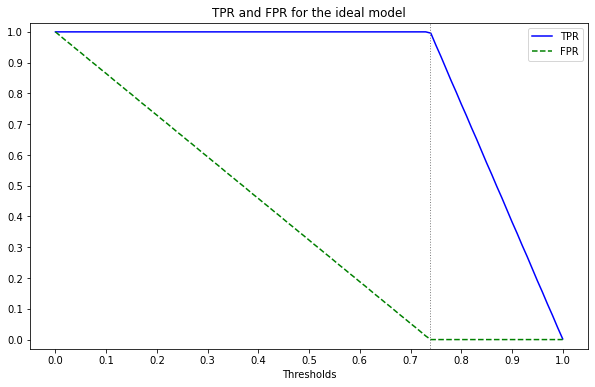

In [61]:
plt.figure(figsize=(10, 6))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='green', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=1, linestyle='dotted', color='grey') # ideal threshold at 0.74
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')


plt.show()

### ROC Curve

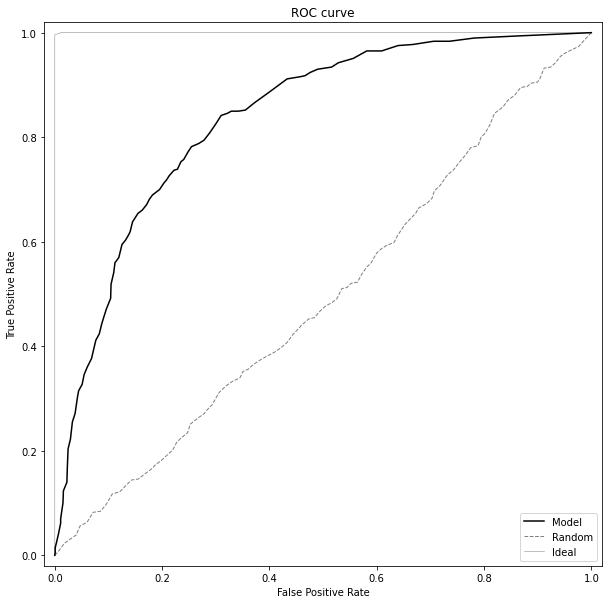

In [62]:
plt.figure(figsize=(10, 10))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')


plt.show()

Although computing all the FPR and TPR values across many thresholds is a good excercise, we don't need to do it ourselves everytime we want to plot an ROC curve 

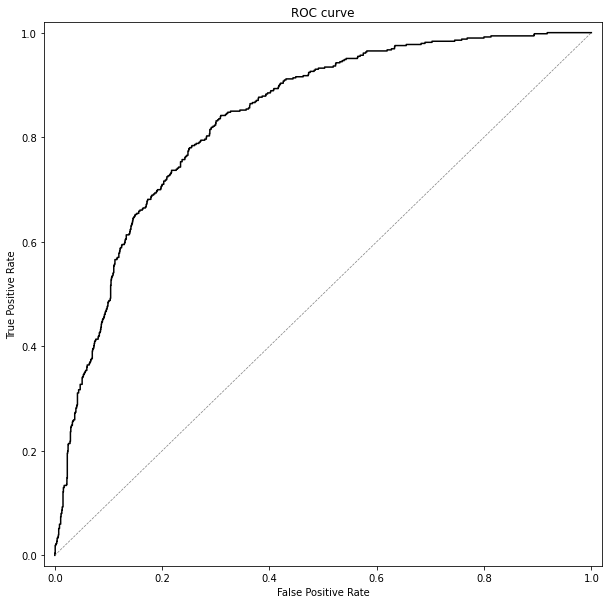

In [63]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

### Comparing ROC curves

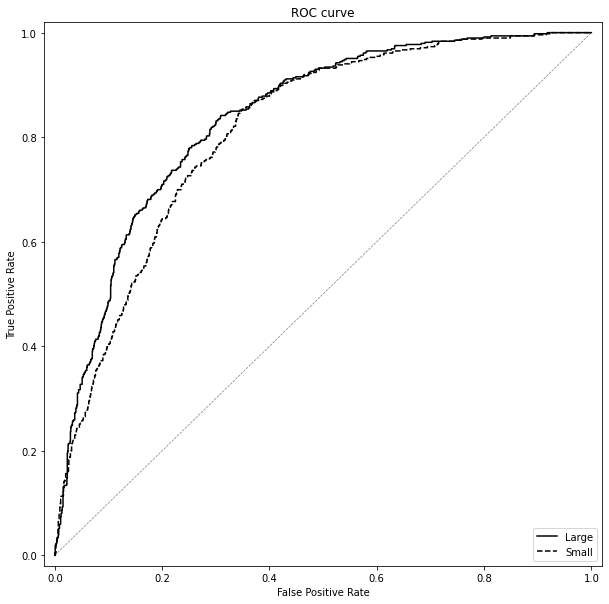

In [64]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(10, 10))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

### AUC

In [65]:
from sklearn.metrics import auc

auc(df_scores.fpr, df_scores.tpr) # AUC for the large model

0.8359150837721111

In [66]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

auc(df_scores_small.fpr, df_scores_small.tpr) # AUC for the small model

0.8108718050089552

We can take a shortcut and use a scikit function to calculate AUC

In [67]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val,y_pred)

0.8363366398907398

In [68]:
roc_auc_score(y_val,y_pred_small)

0.8117942866042492

## K fold cross validation

In [69]:
def train(df,y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear')
    model.fit(X,y)
    
    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [70]:
from sklearn.model_selection import KFold

In [71]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1) # Split data into 10 parts

aucs = [] # creates a list for storing the results

for train_idx, val_idx, in kfold.split(df_train_full): # iterates over the 10 different splits of the data
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    dv,model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

In [72]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.841, 0.844, 0.824, 0.845,
       0.861])

In [73]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


Let's select our cross-validation procedure for selecting the best parameter C

In [74]:
def train(df,y, C):
    cat = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=C)
    
    model.fit(X,y)
    
    return dv,model

In [76]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


Now we need to do the last step:train the model on the entire train and validation datasets and apply it to the test dataset to verify it indeed works well

In [78]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5) # trains the model on the full training dataset
y_pred = predict(df_test,dv,model) # applies to the test dataset

auc = roc_auc_score(y_test, y_pred) # evaluates the predictions on the test data
print('auc = %.3f' % auc)

auc = 0.858
